# PyTorch Model Training Example

This notebook demonstrates how to use the PyTorch model training framework to train and evaluate models on a Hugging Face dataset.

## Setup

First, let's import the necessary modules and set up the environment.

In [1]:
# Add the src directory to the path
import sys
import os

# Get the absolute path to the src directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

print(f"Added to path: {src_dir}")

# Import necessary modules
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix

# Now try importing the custom modules
try:
    # Import utility modules
    from data_utils import create_dataloaders, get_input_size
    from model_utils import (
        SimpleModel, 
        DeepModel, 
        train_model_with_early_stopping, 
        plot_training_history, 
        plot_confusion_matrix,
        evaluate
    )
    from pytorch_model import set_seed, get_device
    print("Successfully imported custom modules from src directory")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print(f"Current sys.path: {sys.path}")
    print(f"Looking for modules in: {src_dir}")
    # List files in the src directory to verify they exist
    print(f"Files in {src_dir}:")
    for file in os.listdir(src_dir):
        if file.endswith('.py'):
            print(f"  {file}")

# Set up matplotlib for inline plotting
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Only proceed if imports were successful
if 'set_seed' in globals():
    # Set random seed for reproducibility
    set_seed(42)
    
    # Get device
    device = get_device()
    print(f"Using device: {device}")
else:
    print("Skipping device setup due to import errors")

Added to path: /Users/esamsoe/Projects/Dev/MPG_Ranch/mpg-horses/src
Successfully imported custom modules from src directory
Random seed set to 42
Using MPS (Metal Performance Shaders) device
Using device: mps


## Load and Explore Dataset

We'll use the Iris dataset from Hugging Face as an example.

In [2]:
# Cell 5 - Code (Updated)
# Load the Iris dataset from scikit-learn
from sklearn.datasets import load_iris
from datasets import Dataset

# Load the iris dataset from scikit-learn
iris = load_iris()
data = {
    'sepal_length': iris.data[:, 0],
    'sepal_width': iris.data[:, 1],
    'petal_length': iris.data[:, 2],
    'petal_width': iris.data[:, 3],
    'label': iris.target  # Using 'label' instead of 'target'
}

# Convert to Hugging Face dataset
dataset = Dataset.from_dict(data)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
print(dataset)

# Inspect the dataset structure
print("\nDataset features:")
print(dataset['train'].features)

# Print a sample
print("\nSample from the dataset:")
print(dataset['train'][0])

# Define the correct label column name
label_col = 'label'  # Update this based on the actual column name

DatasetDict({
    train: Dataset({
        features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'],
        num_rows: 120
    })
    test: Dataset({
        features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'],
        num_rows: 30
    })
})

Dataset features:
{'sepal_length': Value(dtype='float64', id=None), 'sepal_width': Value(dtype='float64', id=None), 'petal_length': Value(dtype='float64', id=None), 'petal_width': Value(dtype='float64', id=None), 'label': Value(dtype='int64', id=None)}

Sample from the dataset:
{'sepal_length': 5.6, 'sepal_width': 2.7, 'petal_length': 4.2, 'petal_width': 1.3, 'label': 1}


Sample from the dataset:
{'sepal_length': 5.6, 'sepal_width': 2.7, 'petal_length': 4.2, 'petal_width': 1.3, 'label': 1}

Dataset summary:
       sepal_length  sepal_width  petal_length  petal_width       label
count    120.000000   120.000000    120.000000   120.000000  120.000000
mean       5.822500     3.054167      3.732500     1.208333    0.991667
std        0.826704     0.442661      1.755096     0.763185    0.814736
min        4.300000     2.000000      1.000000     0.100000    0.000000
25%        5.100000     2.800000      1.575000     0.300000    0.000000
50%        5.750000     3.000000      4.250000     1.300000    1.000000
75%        6.400000     3.300000      5.100000     1.800000    2.000000
max        7.900000     4.400000      6.900000     2.500000    2.000000


<Figure size 1200x800 with 0 Axes>

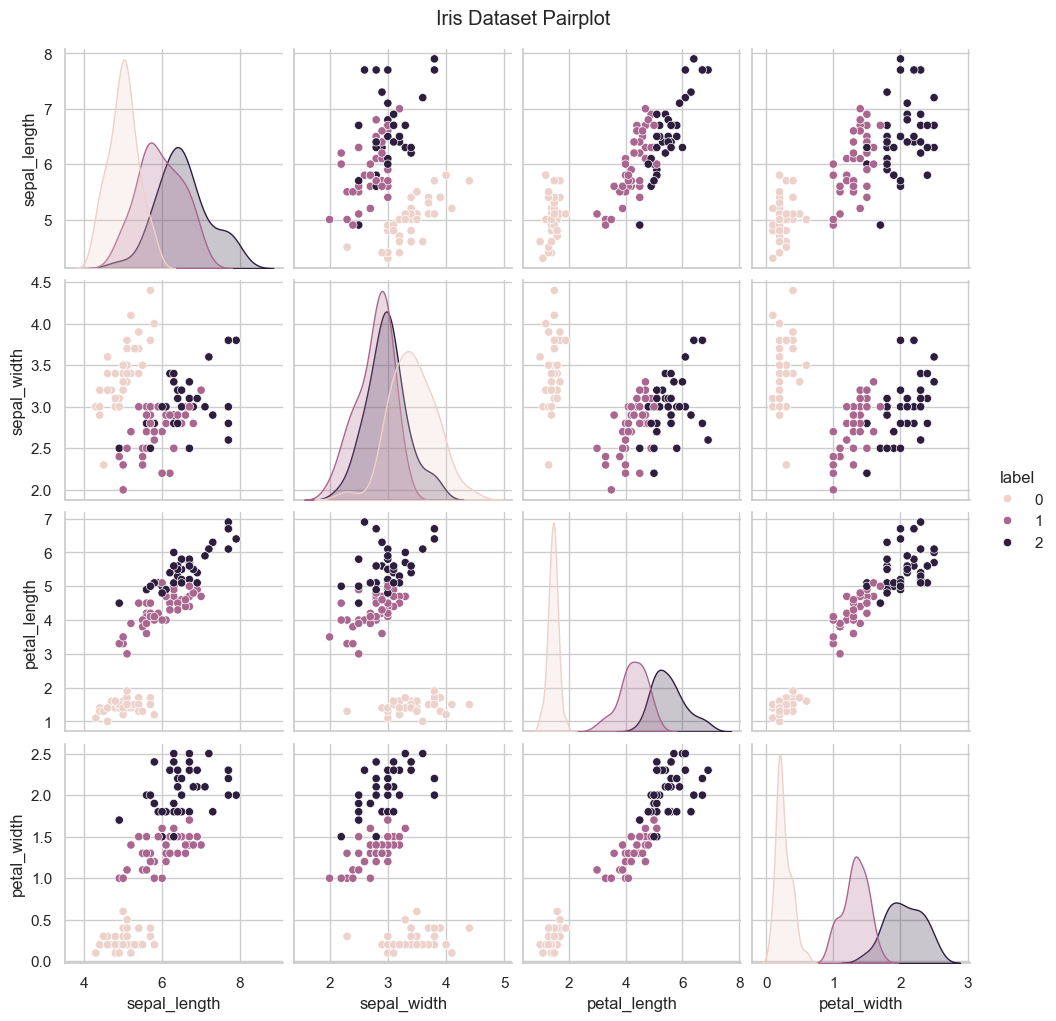

In [3]:
# Explore the dataset
print("Sample from the dataset:")
print(dataset['train'][0])

# Create a pandas DataFrame for easier exploration
df = pd.DataFrame(dataset['train'])
print("\nDataset summary:")
print(df.describe())

# Visualize the dataset
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='label')
plt.suptitle('Iris Dataset Pairplot', y=1.02)
plt.show()

## Preprocess the Dataset

Let's split the dataset into train and test sets and create DataLoaders.

In [4]:
# Cell 8 - Code (Updated)
# Create train/test split if not already present
if 'test' not in dataset.keys():
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    
# Define input columns and label column
input_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
label_col = 'label'  # Updated from 'target' to 'label'

# Create DataLoaders
batch_size = 16
train_loader, test_loader = create_dataloaders(
    dataset,
    input_cols=input_cols,
    label_col=label_col,
    batch_size=batch_size
)

# Get input size and number of classes
input_size = get_input_size(dataset, input_cols)
num_classes = len(set(dataset['train'][label_col]))
print(f"Input size: {input_size}")
print(f"Number of classes: {num_classes}")

Input size: 4
Number of classes: 3


## Train a Simple Model

Let's train a simple linear model on the dataset.

In [5]:
# Create a simple model
simple_model = SimpleModel(input_size=input_size, num_classes=num_classes)
simple_model = simple_model.to(device)
print(simple_model)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01)

# Train model with early stopping
simple_model, simple_history = train_model_with_early_stopping(
    model=simple_model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=50,
    patience=5
)

SimpleModel(
  (fc): Linear(in_features=4, out_features=3, bias=True)
)

Epoch 1/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 95.12it/s]


Train Loss: 1.8772, Val Loss: 1.2853, F1 Score: 0.5699
New best F1 score: 0.5699

Epoch 2/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 358.86it/s]


Train Loss: 1.1916, Val Loss: 0.8164, F1 Score: 0.5699
F1 score did not improve. Counter: 1/5

Epoch 3/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 439.95it/s]


Train Loss: 0.8500, Val Loss: 0.7993, F1 Score: 0.3889
F1 score did not improve. Counter: 2/5

Epoch 4/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 456.75it/s]


Train Loss: 0.8355, Val Loss: 0.7515, F1 Score: 0.5600
F1 score did not improve. Counter: 3/5

Epoch 5/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 477.09it/s]


Train Loss: 0.7698, Val Loss: 0.6778, F1 Score: 0.6444
New best F1 score: 0.6444

Epoch 6/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 409.16it/s]


Train Loss: 0.7229, Val Loss: 0.6466, F1 Score: 0.6444
F1 score did not improve. Counter: 1/5

Epoch 7/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 452.61it/s]


Train Loss: 0.6993, Val Loss: 0.6274, F1 Score: 0.8933
New best F1 score: 0.8933

Epoch 8/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 415.03it/s]


Train Loss: 0.6465, Val Loss: 0.5975, F1 Score: 0.7074
F1 score did not improve. Counter: 1/5

Epoch 9/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 397.17it/s]


Train Loss: 0.6296, Val Loss: 0.5777, F1 Score: 0.6444
F1 score did not improve. Counter: 2/5

Epoch 10/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 469.92it/s]


Train Loss: 0.6174, Val Loss: 0.5596, F1 Score: 0.7619
F1 score did not improve. Counter: 3/5

Epoch 11/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 432.14it/s]


Train Loss: 0.5943, Val Loss: 0.5490, F1 Score: 0.9306
New best F1 score: 0.9306

Epoch 12/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 505.58it/s]


Train Loss: 0.5917, Val Loss: 0.5409, F1 Score: 0.8997
F1 score did not improve. Counter: 1/5

Epoch 13/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 447.73it/s]


Train Loss: 0.5680, Val Loss: 0.5160, F1 Score: 0.8101
F1 score did not improve. Counter: 2/5

Epoch 14/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 470.27it/s]


Train Loss: 0.5375, Val Loss: 0.5053, F1 Score: 0.7074
F1 score did not improve. Counter: 3/5

Epoch 15/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 491.37it/s]


Train Loss: 0.5369, Val Loss: 0.4946, F1 Score: 0.9306
F1 score did not improve. Counter: 4/5

Epoch 16/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 483.69it/s]


Train Loss: 0.5278, Val Loss: 0.4901, F1 Score: 0.9659
New best F1 score: 0.9659

Epoch 17/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 485.93it/s]


Train Loss: 0.5211, Val Loss: 0.4754, F1 Score: 0.9306
F1 score did not improve. Counter: 1/5

Epoch 18/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 450.27it/s]


Train Loss: 0.4920, Val Loss: 0.4676, F1 Score: 0.9306
F1 score did not improve. Counter: 2/5

Epoch 19/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 455.16it/s]


Train Loss: 0.5004, Val Loss: 0.4575, F1 Score: 0.8101
F1 score did not improve. Counter: 3/5

Epoch 20/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 438.62it/s]


Train Loss: 0.4825, Val Loss: 0.4547, F1 Score: 0.9659
F1 score did not improve. Counter: 4/5

Epoch 21/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 424.18it/s]

Train Loss: 0.4781, Val Loss: 0.4465, F1 Score: 0.9659
F1 score did not improve. Counter: 5/5
Early stopping triggered after 21 epochs


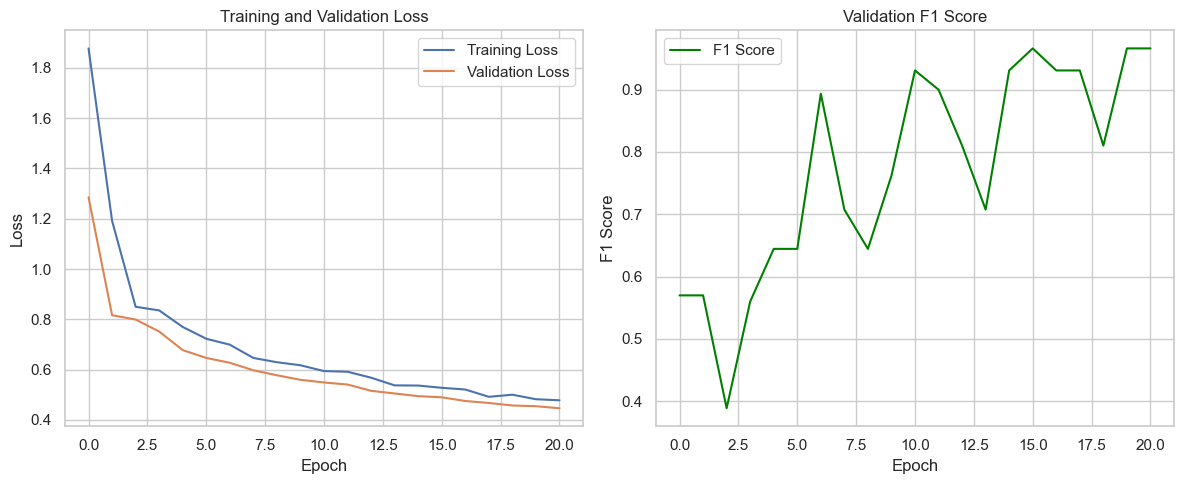

In [6]:
# Plot training history
plot_training_history(
    train_losses=simple_history['train_losses'],
    val_losses=simple_history['val_losses'],
    f1_scores=simple_history['f1_scores']
)

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 238.97it/s]


Classification Report (Simple Model):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



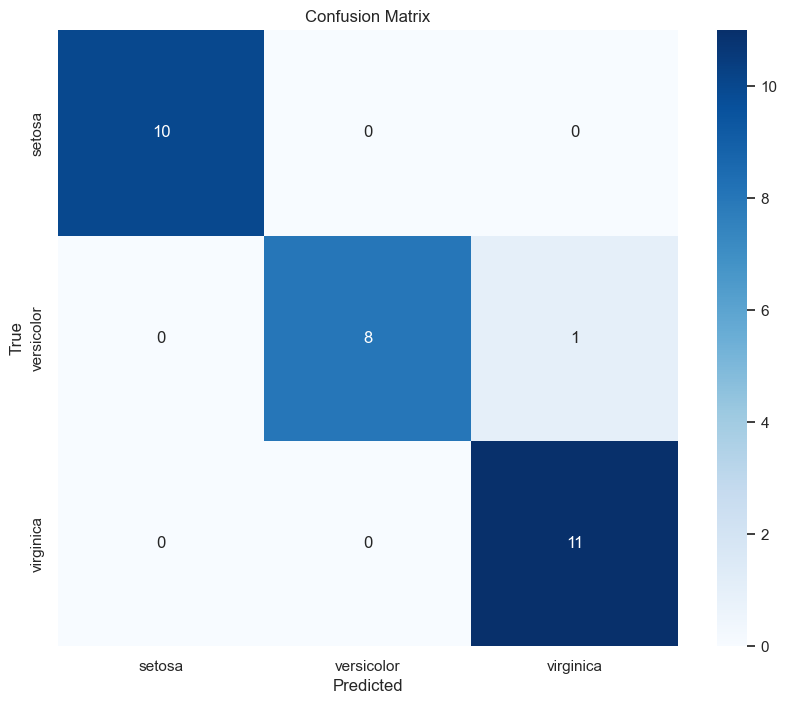

In [7]:
# Evaluate the model
_, f1, preds, labels = evaluate(
    model=simple_model,
    dataloader=test_loader,
    criterion=criterion,
    device=device
)

# Print classification report
target_names = ['setosa', 'versicolor', 'virginica']
print("Classification Report (Simple Model):")
print(classification_report(labels, preds, target_names=target_names))

# Plot confusion matrix
plot_confusion_matrix(y_true=labels, y_pred=preds, classes=target_names)

## Train a Deep Model

Now, let's train a deep neural network on the same dataset.

In [8]:
# Create a deep model
deep_model = DeepModel(
    input_size=input_size, 
    hidden_size=64, 
    num_classes=num_classes,
    dropout_rate=0.2
)
deep_model = deep_model.to(device)
print(deep_model)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.01)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.1, 
    patience=3, 
    verbose=True
)

# Train model with early stopping
deep_model, deep_history = train_model_with_early_stopping(
    model=deep_model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=50,
    patience=5,
    scheduler=scheduler
)

/Users/esamsoe/miniforge3/envs/mpg-horses/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


DeepModel(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

Epoch 1/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.81it/s]


Train Loss: 1.0556, Val Loss: 0.7644, F1 Score: 0.5699
New best F1 score: 0.5699

Epoch 2/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 304.77it/s]


Train Loss: 0.6618, Val Loss: 0.4473, F1 Score: 0.8933
New best F1 score: 0.8933

Epoch 3/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 375.87it/s]


Train Loss: 0.4153, Val Loss: 0.3100, F1 Score: 0.8997
New best F1 score: 0.8997

Epoch 4/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 423.45it/s]


Train Loss: 0.2821, Val Loss: 0.2059, F1 Score: 0.9659
New best F1 score: 0.9659

Epoch 5/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 411.25it/s]


Train Loss: 0.2321, Val Loss: 0.1661, F1 Score: 0.9327
F1 score did not improve. Counter: 1/5

Epoch 6/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 347.64it/s]


Train Loss: 0.1964, Val Loss: 0.2296, F1 Score: 0.8653
F1 score did not improve. Counter: 2/5

Epoch 7/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 410.92it/s]


Train Loss: 0.1318, Val Loss: 0.1597, F1 Score: 0.9659
F1 score did not improve. Counter: 3/5

Epoch 8/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 421.75it/s]


Train Loss: 0.1292, Val Loss: 0.1173, F1 Score: 0.9659
F1 score did not improve. Counter: 4/5

Epoch 9/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 365.48it/s]

Train Loss: 0.1431, Val Loss: 0.1220, F1 Score: 0.9327
F1 score did not improve. Counter: 5/5
Early stopping triggered after 9 epochs


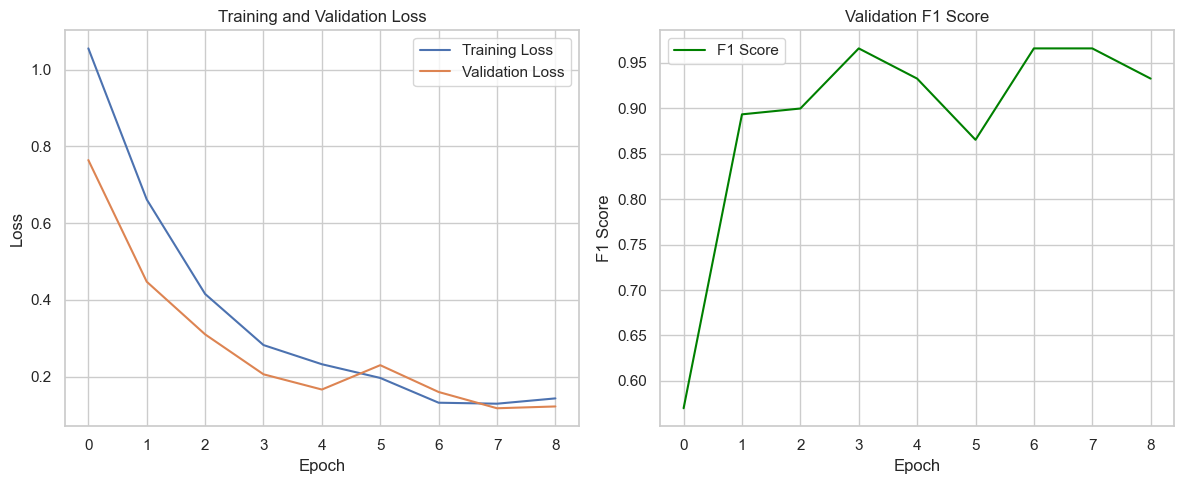

In [9]:
# Plot training history
plot_training_history(
    train_losses=deep_history['train_losses'],
    val_losses=deep_history['val_losses'],
    f1_scores=deep_history['f1_scores']
)

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 130.58it/s]

Classification Report (Deep Model):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.89      0.89      0.89         9
   virginica       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



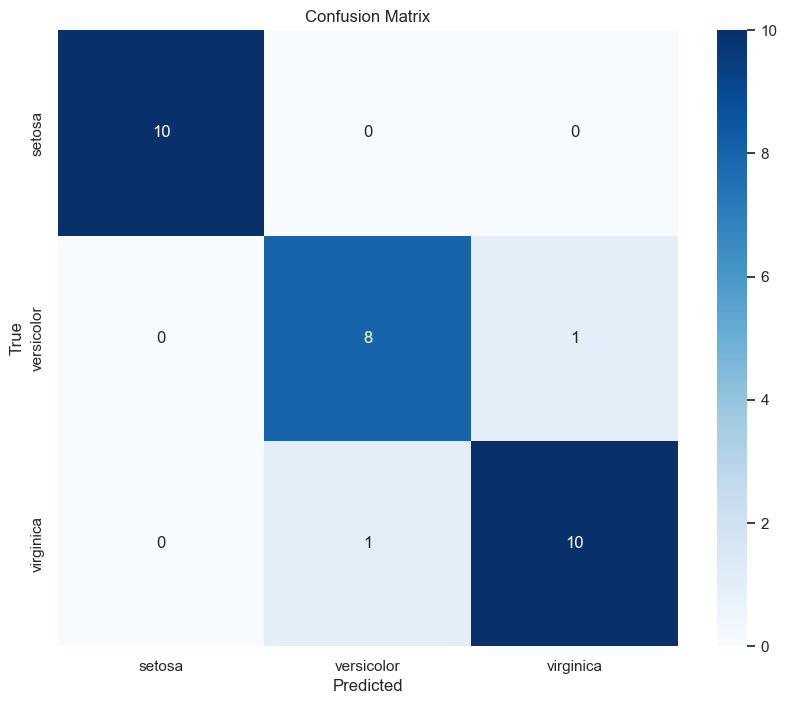

In [10]:
# Evaluate the model
_, f1, preds, labels = evaluate(
    model=deep_model,
    dataloader=test_loader,
    criterion=criterion,
    device=device
)

# Print classification report
print("Classification Report (Deep Model):")
print(classification_report(labels, preds, target_names=target_names))

# Plot confusion matrix
plot_confusion_matrix(y_true=labels, y_pred=preds, classes=target_names)

## Compare Models

Let's compare the performance of the simple and deep models.

Model Comparison:
Simple Model Best F1 Score: 0.9659
Deep Model Best F1 Score: 0.9659


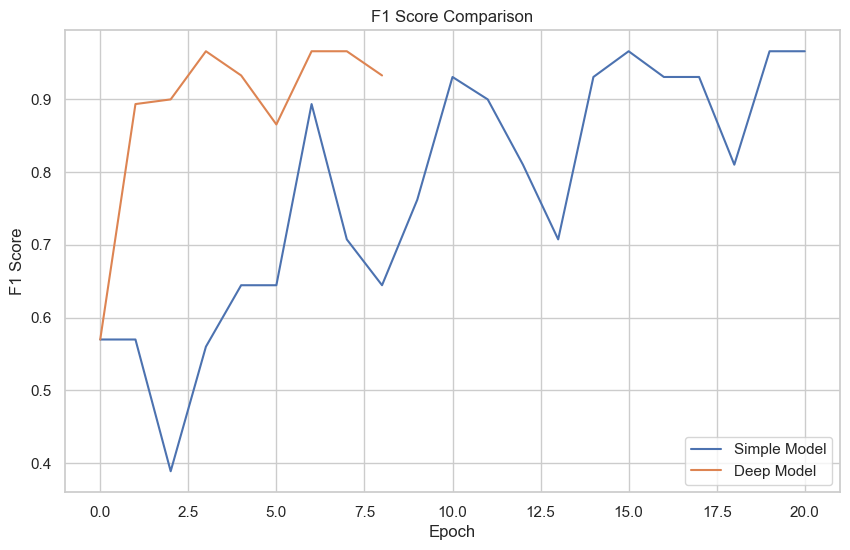

In [11]:
# Compare models
print("Model Comparison:")
print(f"Simple Model Best F1 Score: {simple_history['best_f1']:.4f}")
print(f"Deep Model Best F1 Score: {deep_history['best_f1']:.4f}")

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.plot(simple_history['f1_scores'], label='Simple Model')
plt.plot(deep_history['f1_scores'], label='Deep Model')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Save Models

Finally, let's save the trained models for future use.

In [12]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save models
torch.save(simple_model.state_dict(), '../models/simple_model_iris.pt')
torch.save(deep_model.state_dict(), '../models/deep_model_iris.pt')
print("Models saved to ../models/")

Models saved to ../models/


## Conclusion

In this notebook, we demonstrated how to use the PyTorch model training framework to train and evaluate models on the Iris dataset. We trained both a simple linear model and a deep neural network, and compared their performance using F1 score.

The framework provides a modular and extensible approach to model training, with separate modules for data preprocessing, model definitions, and training utilities. It also includes utilities for visualization and metrics calculation, making it easy to understand model performance.